In [1]:
import pandas as pd
import numpy as np
from feature_engine.imputation import MeanMedianImputer

# 模拟医学数据集
data = {'patient_id': [1, 2, 3, 4, 5],
        'age': [65, 72, np.nan, 58, 69],
        'albumin': [3.5, np.nan, 3.2, 4.1, 3.8]}
df = pd.DataFrame(data)

df

,patient_id,age,albumin
0,1,65.0,3.5
1,2,72.0,NaN
2,3,NaN,3.2
3,4,58.0,4.1
4,5,69.0,3.8


In [2]:
# 初始化中位数插补器，仅作用于'age'和'albumin'
imputer = MeanMedianImputer(imputation_method='median', variables=['age', 'albumin'])

# 学习（fit）数据中的中位数
imputer.fit(df)

# 查看学习到的中位数
print("学习到的中位数:", imputer.imputer_dict_)

# 转换（transform）数据
df_imputed = imputer.transform(df)
print("插补后的数据:\n", df_imputed)

学习到的中位数: {'age': 67.0, 'albumin': 3.65}
插补后的数据:
    patient_id   age  albumin
0           1  65.0     3.50
1           2  72.0     3.65
2           3  67.0     3.20
3           4  58.0     4.10
4           5  69.0     3.80


In [3]:
from feature_engine.imputation import CategoricalImputer

data = {'patient_id': [1, 2, 3, 4],
        'smoking_status': ['Smoker', 'Non-smoker', np.nan, 'Smoker']}
df_cat = pd.DataFrame(data)

df_cat

,patient_id,smoking_status
0,1,Smoker
1,2,Non-smoker
2,3,NaN
3,4,Smoker


In [4]:

# 初始化分类插补器，用'Unknown'填充
cat_imputer = CategoricalImputer(imputation_method='missing', fill_value='Unknown', variables=['smoking_status'])

# 学习并转换
df_cat_imputed = cat_imputer.fit_transform(df_cat)
print("分类插补后的数据:\n", df_cat_imputed)

分类插补后的数据:
    patient_id smoking_status
0           1         Smoker
1           2     Non-smoker
2           3        Unknown
3           4         Smoker


In [5]:
from feature_engine.imputation import AddMissingIndicator

# 使用上一个例子中的df
indicator = AddMissingIndicator(variables=['albumin'])
df_indicator = indicator.fit_transform(df)

print("添加缺失指示器后的数据:\n", df_indicator)

添加缺失指示器后的数据:
    patient_id   age  albumin  albumin_na
0           1  65.0      3.5           0
1           2  72.0      NaN           1
2           3   NaN      3.2           0
3           4  58.0      4.1           0
4           5  69.0      3.8           0


In [6]:
from feature_engine.outliers import Winsorizer

data = {'systolic_bp': [120, 130, 115, 180, 122, 128, 90, 135]}
df_bp = pd.DataFrame(data)

df_bp

,systolic_bp
0,120
1,130
2,115
3,180
4,122
5,128
6,90
7,135


In [7]:
# 初始化Winsorizer，capping_method='quantiles'表示使用分位数
# tail='both'表示同时处理上下限
winsoriser = Winsorizer(capping_method='quantiles', tail='both', fold=0.05, variables=['systolic_bp'])

df_winsorised = winsoriser.fit_transform(df_bp)
print("Winsor化处理后的数据:\n", df_winsorised)

Winsor化处理后的数据:
    systolic_bp
0       120.00
1       130.00
2       115.00
3       164.25
4       122.00
5       128.00
6        98.75
7       135.00


In [8]:
from feature_engine.encoding import MeanEncoder

data = {'hospital': ['A', 'B', 'A', 'C', 'B', 'C', 'A', 'B'],
        'infection': [1, 0, 0, 1, 1, 0, 0, 0]}
df_hosp = pd.DataFrame(data)

df_hosp


,hospital,infection
0,A,1
1,B,0
2,A,0
3,C,1
4,B,1
5,C,0
6,A,0
7,B,0


In [9]:

# 划分训练集和测试集以演示
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_hosp[['hospital']], df_hosp['infection'], test_size=0.3, random_state=0)

# 初始化MeanEncoder
mean_encoder = MeanEncoder(variables=['hospital'])

# 在训练集上学习编码映射
mean_encoder.fit(X_train, y_train)

# 查看学习到的映射
print("学习到的编码映射:", mean_encoder.encoder_dict_)


学习到的编码映射: {'hospital': {'A': 1.0, 'B': 0.5, 'C': 0.5}}


In [10]:

# 转换训练集和测试集
X_train_enc = mean_encoder.transform(X_train)
X_test_enc = mean_encoder.transform(X_test)

print("\n转换后的训练集:\n", X_train_enc)
print("\n转换后的测试集:\n", X_test_enc)


转换后的训练集:
    hospital
7       0.5
3       0.5
0       1.0
5       0.5
4       0.5

转换后的测试集:
    hospital
6       1.0
2       1.0
1       0.5


In [11]:
from feature_engine.discretisation import DecisionTreeDiscretiser

data = {'age': [25, 30, 65, 70, 45, 50, 22, 80],
        'disease_status': [0, 0, 1, 1, 0, 1, 0, 1]}
df_age = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(df_age[['age']], df_age['disease_status'], test_size=0.3, random_state=0)

df_age

,age,disease_status
0,25,0
1,30,0
2,65,1
3,70,1
4,45,0
5,50,1
6,22,0
7,80,1


In [12]:
# 初始化决策树离散化器
# cv=3 表示使用3折交叉验证来确定树的深度，防止过拟合
# scoring='roc_auc' 使用AUC作为评估指标
tree_discretiser = DecisionTreeDiscretiser(cv=3, scoring='roc_auc', variables=['age'], regression=False)

# 在训练集上学习最佳分割点
tree_discretiser.fit(X_train, y_train)

# 查看学习到的分割点
print("学习到的分割点:", tree_discretiser.binner_dict_)

# 转换数据
X_train_disc = tree_discretiser.transform(X_train)
print("\n转换后的训练集:\n", X_train_disc)

学习到的分割点: {'age': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4]}, scoring='roc_auc')}

转换后的训练集:
    age
7  1.0
3  1.0
0  0.0
5  1.0
4  0.0


d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
d:\Analysis\Anaconda3\envs\datasci\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined

In [13]:
from feature_engine.transformation import BoxCoxTransformer

data = {'marker_x': np.random.lognormal(size=100)} # 模拟一个右偏数据
df_marker = pd.DataFrame(data)

df_marker

,marker_x
0,0.520890
1,1.033331
2,1.307745
3,2.617718
4,1.003968
...,...
95,3.728110
96,1.590866
97,0.540459
98,0.630827


In [14]:
# 初始化Box-Cox变换器
bct = BoxCoxTransformer(variables=['marker_x'])

# 学习并转换
df_transformed = bct.fit_transform(df_marker)

df_transformed

,marker_x
0,-0.637732
1,0.032825
2,0.270808
3,0.995030
4,0.003960
...,...
95,1.377606
96,0.471809
97,-0.602434
98,-0.453465


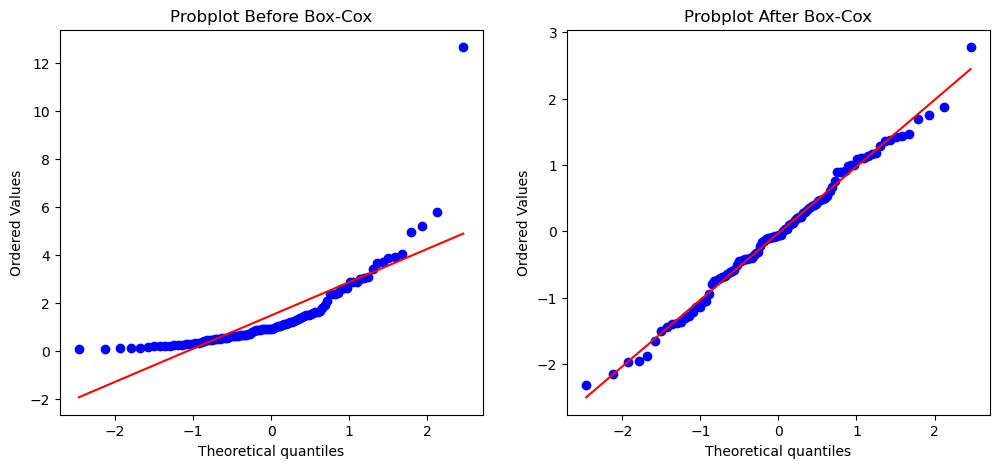

In [15]:
# 比较变换前后的分布（可视化）
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(df_marker['marker_x'], dist="norm", plot=plt)
plt.title("Probplot Before Box-Cox")

plt.subplot(1, 2, 2)
stats.probplot(df_transformed['marker_x'], dist="norm", plot=plt)
plt.title("Probplot After Box-Cox")
plt.show()

In [17]:
from feature_engine.datetime import DatetimeFeatures

data = {'admission_date': pd.to_datetime(['2024-01-15', '2024-02-20', '2024-03-30'])}
df_date = pd.DataFrame(data)

df_date

,admission_date
0,2024-01-15
1,2024-02-20
2,2024-03-30


In [19]:

# 初始化DatetimeFeatures
# features_to_extract可以指定要提取的特征列表
dtf = DatetimeFeatures(variables=['admission_date'], features_to_extract=['month', 'week', 'day_of_week', 'day_of_year'])

df_dt_featured = dtf.fit_transform(df_date)
df_dt_featured

,admission_date_month,admission_date_week,admission_date_day_of_week,admission_date_day_of_year
0,1,3,0,15
1,2,8,1,51
2,3,13,5,90


In [20]:
from feature_engine.selection import DropCorrelatedFeatures

# 模拟一个高相关的基因表达矩阵
data = {'gene1': [1, 2, 3, 4],
        'gene2': [1.1, 2.2, 3.1, 4.2], # 与gene1高度相关
        'gene3': [4, 1, 2, 3]}
df_genes = pd.DataFrame(data)

# 初始化相关性选择器
corr_selector = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.9)

# 学习并转换
df_genes_selected = corr_selector.fit_transform(df_genes)

print("被删除的特征:", corr_selector.features_to_drop_)
print("选择后的数据:\n", df_genes_selected)

被删除的特征: ['gene2']
选择后的数据:
    gene1  gene3
0      1      4
1      2      1
2      3      2
3      4      3


In [33]:
import pandas as pd  # 导入pandas库用于数据处理
import numpy as np   # 导入numpy库用于数值计算和生成随机数
from sklearn.datasets import make_classification  # 从sklearn导入生成分类数据的函数

# 设置随机种子，确保每次运行生成的随机数据是一致的
np.random.seed(42)

# 1. 使用 sklearn 生成基础的数值型特征和目标变量
# n_samples=1000: 生成1000个样本
# n_features=10: 总共生成10个特征
# n_informative=5: 其中5个特征是与目标变量强相关的（有信息的）
# n_redundant=2: 其中2个特征是冗余的（由有信息的特征线性组合而成）
# n_classes=2: 二分类问题
X, y = make_classification(
    n_samples=1000, 
    n_features=10, 
    n_informative=5, 
    n_redundant=2, 
    n_classes=2, 
    random_state=42
)

# 将生成的数值特征数组转换为 Pandas DataFrame
# 特征列命名为 feature_0 到 feature_9
feature_names = [f'feature_{i}' for i in range(10)]
df = pd.DataFrame(X, columns=feature_names)

# 2. 添加分类特征 (Categorical Features)
# 生成一个名为 'cat_1' 的分类列，包含 'A', 'B', 'C' 三种类别
df['cat_1'] = np.random.choice(['A', 'B', 'C'], size=1000)

# 生成一个名为 'cat_2' 的分类列，包含 'High', 'Medium', 'Low' 三种类别
df['cat_2'] = np.random.choice(['High', 'Medium', 'Low'], size=1000)

# 4. 将目标变量 (Target) 添加到 DataFrame 中
df['target'] = y

# 打印数据的前5行，查看数据结构
print("生成的测试数据前5行:")
print(df.head())


生成的测试数据前5行:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.125100   1.178124   0.493516   0.790880  -0.614278   1.347020   
1  -0.564641   3.638629  -1.522415  -1.541705   1.616697   4.781310   
2   0.516313   2.165426  -0.628486  -0.386923   0.492518   1.442381   
3   0.537282   0.966618  -0.115420   0.670755  -0.958516   0.871440   
4   0.278385   1.065828  -1.724917  -2.235667   0.715107   0.731249   

   feature_6  feature_7  feature_8  feature_9 cat_1 cat_2  target  
0   1.419515   1.357325   0.966041  -1.981139     C   Low       1  
1   3.190292  -0.890254   1.438826  -3.828748     A   Low       0  
2   1.332905  -1.958175  -0.348803  -1.804124     C   Low       0  
3   0.508186  -1.034471  -1.654176  -1.910503     C   Low       1  
4  -0.674119   0.598330  -0.524283   1.047610     A  High       0  


In [34]:
X_train = df.drop(columns=["target"])

In [ ]:
X_train.isna().sum()

feature_0    0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
feature_8    0
feature_9    0
cat_1        0
cat_2        0
dtype: int64

In [37]:
from sklearn.linear_model import LogisticRegression
from feature_engine.selection import RecursiveFeatureElimination

# 假设X_train是包含10个基因表达量的训练数据，y_train是疾病状态
# (此处省略数据生成代码)

# 初始化RFE选择器
# estimator是用于评估特征重要性的模型
# scoring是评估指标
# cv是交叉验证折数
rfe_selector = RecursiveFeatureElimination(
    estimator=LogisticRegression(random_state=42),
    scoring='roc_auc',
    cv=5,
    variables=None # 对所有特征进行操作
)

#学习最佳特征子集
rfe_selector.fit(X_train, y_train)

#查看被移除的特征
print("被移除的特征:", rfe_selector.features_to_drop_)
#查看最终选择的特征
print("最终选择的特征:", rfe_selector.get_support(indices=True))

被移除的特征: ['feature_1', 'feature_2', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
最终选择的特征: [ 0  3  4  5 10 11]


In [42]:
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

data = {'patient_id': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
        'time_step': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
        'heart_rate': [70, 72, 75, 73, 74, 80, 82, 81, 84, 83]}
df_hr = pd.DataFrame(data)

df_hr

,patient_id,time_step,heart_rate
0,1,1,70
1,1,2,72
2,1,3,75
3,1,4,73
4,1,5,74
5,2,1,80
6,2,2,82
7,2,3,81
8,2,4,84
9,2,5,83


In [47]:

# 创建滞后特征（过去1小时和2小时的心率）
# groupby='patient_id' 确保滞后计算在每个患者内部进行，不会跨患者
lag_creator = LagFeatures(variables=['heart_rate'], periods=[1, 2], drop_original=False)
df_lag = lag_creator.fit_transform(df_hr)

df_lag

,patient_id,time_step,heart_rate,heart_rate_lag_1,heart_rate_lag_2
0,1,1,70,NaN,NaN
1,1,2,72,70.0,NaN
2,1,3,75,72.0,70.0
3,1,4,73,75.0,72.0
4,1,5,74,73.0,75.0
5,2,1,80,74.0,73.0
6,2,2,82,80.0,74.0
7,2,3,81,82.0,80.0
8,2,4,84,81.0,82.0
9,2,5,83,84.0,81.0


In [48]:

# 创建窗口特征（过去3小时心率的均值和标准差）
win_creator = WindowFeatures(variables=['heart_rate'], window=3, functions=['mean', 'std'])
df_win = win_creator.fit_transform(df_lag)

df_win

,patient_id,time_step,heart_rate,heart_rate_lag_1,heart_rate_lag_2,heart_rate_window_3_mean,heart_rate_window_3_std
0,1,1,70,NaN,NaN,NaN,NaN
1,1,2,72,70.0,NaN,NaN,NaN
2,1,3,75,72.0,70.0,NaN,NaN
3,1,4,73,75.0,72.0,72.333333,2.516611
4,1,5,74,73.0,75.0,73.333333,1.527525
5,2,1,80,74.0,73.0,74.000000,1.000000
6,2,2,82,80.0,74.0,75.666667,3.785939
7,2,3,81,82.0,80.0,78.666667,4.163332
8,2,4,84,81.0,82.0,81.000000,1.000000
9,2,5,83,84.0,81.0,82.333333,1.527525


In [51]:

    # 模拟医学数据集 (Notebook 中的原始数据)
data = {
        'patient_id': [1, 2, 3, 4, 5],
        'age': [65, 72, np.nan, 58, 69],
        'albumin': [3.5, np.nan, 3.2, 4.1, 3.8]
    }
df = pd.DataFrame(data)
    
print("原始数据:\n", df)
    

原始数据:
    patient_id   age  albumin
0           1  65.0      3.5
1           2  72.0      NaN
2           3   NaN      3.2
3           4  58.0      4.1
4           5  69.0      3.8


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import MeanMedianImputer, AddMissingIndicator
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropCorrelatedFeatures

# 假设X_train, y_train已准备好，包含数值和分类变量

# 定义数值变量和分类变量列表
numerical_vars = ['age', 'bmi', 'systolic_bp']
categorical_vars = ['gender', 'smoking_status']

# 构建Pipeline
ml_pipeline = Pipeline([
    # 1. 缺失值处理
    ('missing_indicator', AddMissingIndicator(variables=numerical_vars)),
    ('median_imputer', MeanMedianImputer(imputation_method='median', variables=numerical_vars)),

    # 2. 分类变量编码
    ('onehot_encoder', OneHotEncoder(variables=categorical_vars, drop_last=True)),

    # 3. 特征选择：删除冗余特征
    ('corr_selector', DropCorrelatedFeatures(threshold=0.8)),

    # 4. 特征缩放
    ('scaler', StandardScaler()),

    # 5. 模型训练
    ('model', RandomForestClassifier(random_state=42))
])


In [ ]:

# 像使用普通模型一样训练整个Pipeline
ml_pipeline.fit(X_train, y_train)

# 进行预测
predictions = ml_pipeline.predict(X_test)

In [ ]:
import pickle
pickle.dump(ml_pipeline, open('my_prediction_pipeline.pkl', 'wb'))